## Using FAST.AI for NLP

Exploring the MIMIC III data set medical notes.

Tried working with the full dataset, but almost every training step takes many hours (~13 for initial training), predicted 14+ per epoch for fine tuning.

Instead will try to work with just 10% sample... Not sure that will work though

A few notes:
* See https://docs.fast.ai/text.transform.html#Tokenizer for details on what various artificial tokens (e.g xxup, xxmaj, etc.) mean
* Due to a change in the markdown package private API, the 'doc' functionality (e.g. ` doc(learn.lr_find)`) is currently broken. See https://github.com/fastai/fastai/commit/21faa5d187b2cccf2a48315d183c2863ed2cdc50

In [1]:
from fastai.text import *
from sklearn.model_selection import train_test_split

In [2]:
# run this to see what has already been imported
#whos

In [3]:
# pandas doesn't understand ~, so provide full path
base_path = Path('/home/jupyter/mimic')
seed = 42
# previously used 48; worked fine but never seemed to use even half of GPU memory; 64 still on the small side
bs=128

In [4]:
# run this the first time to covert CSV to Pickle file
df = pd.read_csv(base_path/'NOTEEVENTS.csv', low_memory=False, memory_map=True)
df.to_pickle(base_path/'noteevents.pickle')

In [5]:
filename = base_path/'noteevents.pickle'

if os.path.isfile(filename):
    # this is much faster than reading a csv
    orig_df = pd.read_pickle(filename)
else:
    print('Could not find noteevent pickle file; creating it')
    # run this the first time to covert CSV to Pickle file
    orig_df = pd.read_csv(base_path/'NOTEEVENTS.csv', low_memory=False, memory_map=True)
    orig_df.to_pickle(filename)

In [6]:
df = orig_df.sample(frac=0.1, random_state=seed)

In [7]:
df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
1292716,1295263,2549,159440.0,2132-04-02,2132-04-02 13:09:00,2132-04-02 13:35:00,Nursing/other,Report,18566.0,NaN,CCU NSG TRANSFER SUMMARY UPDATE: RESP FAILURE\...
1160271,1175599,29621,190624.0,2149-02-23,2149-02-23 03:27:00,NaN,Radiology,CHEST (PORTABLE AP),NaN,NaN,[**2149-2-23**] 3:27 AM\n CHEST (PORTABLE AP) ...
1549380,1555118,22384,142591.0,2185-03-26,2185-03-26 17:58:00,2185-03-26 18:01:00,Nursing/other,Report,16985.0,NaN,Respiratory Care\nPt remains intubated (#7.5 E...
7474,5743,690,152820.0,2182-09-14,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2182-9-12**] Dischar...
2014768,2023163,25560,156143.0,2154-11-18,2154-11-18 10:44:00,2154-11-18 17:08:00,Nursing/other,Report,16888.0,NaN,Neonatology\nOn exam pink active non-dysmorphi...


In [8]:
df.dtypes

ROW_ID           int64
SUBJECT_ID       int64
HADM_ID        float64
CHARTDATE       object
CHARTTIME       object
STORETIME       object
CATEGORY        object
DESCRIPTION     object
CGID           float64
ISERROR        float64
TEXT            object
dtype: object

In [9]:
df.shape

(208318, 11)

In [10]:
# split data into train and test sets
test_size = 0.333333333
train, test = train_test_split(df, test_size=test_size, random_state=seed)

In [11]:
train.shape

(138878, 11)

In [12]:
test.shape

(69440, 11)

Code to reload previously built language model

```python
filename = base_path/'mimic_lm.pickle'

if os.path.isfile(filename):
    data_lm = load_data(base_path, 'mimic_lm.pickle', bs=bs)
else:
    print('Couldnt find file')
```

Code to build initial version of language model

Questions:

* why does this only seem to use CPU? (applies to both both textclasdatabunch and textlist)
* for 100% of the mimic noteevents data:
  * run out of memory at 32 GB, error at 52 GB, trying 72GB now... got down to only 440MB free; if crash again, increase memory
  * now at 20vCPU and 128GB RAM; ok up to 93%; got down to 22GB available
  * succeeded with 20CPU and 128GB RAM...
* try smaller batch size? will that reduce memory requirements?
* with 10% dataset sample, it seems I could get by with perhaps 32GB system RAM

In [13]:
filename = base_path/'mimic_lm.pickle'
file = 'mimic_lm.pickle'

if os.path.isfile(filename):
    data_lm = load_data(base_path, file, bs=bs)
else:
    data_lm = (TextList.from_df(df, 'texts.csv', cols='TEXT')
               #We may have other temp folders that contain text files so we only keep what's in train and test
               .split_by_rand_pct(0.1)
               #We randomly split and keep 10% for validation
               .label_for_lm()
               #We want to do a language model so we label accordingly
               .databunch(bs=bs))
    data_lm.save(filename)

If need to view more data, run appropriate line to make display wider/show more columns...
```python
# default 20
pd.get_option('display.max_columns')
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_columns', None) # show all
# default 50
pd.get_option('display.max_colwidth')
pd.set_option('display.max_colwidth', -1) # show all
```

In [16]:
data_lm.show_batch()
# how to look at original version of text
#df[df['TEXT'].str.contains('being paralyzed were discussed', case=False)].TEXT

idx,text
0,pacs . xxmaj bp went back to 150 / 80 . xxup hr varies between 80s to low 90s at rest up to 1-teens with activity . xxup bp varies more widely between 1-teens / 70s at rest up to 170 / 90s with activity . xxmaj she continues on dilt 90 mg po qid . xxmaj she was xxup k+ replaced today . \n xxup resp : xxmaj
1,: xxmaj nasal \n xxmaj type : xxmaj standard \n xxmaj size : 6.5 mm \n xxmaj cuff xxmaj management : \n xxmaj vol / xxmaj press : \n xxmaj cuff pressure : 25 cmh2o \n xxmaj lung sounds \n xxup rll xxmaj lung xxmaj sounds : xxmaj clear \n xxup rul xxmaj lung xxmaj sounds : xxmaj clear \n xxup
2,\n 18 xxmaj gauge - [ * * 2156 - 2 - 1 * * ] 08:25 xxup am \n 20 xxmaj gauge - [ * * 2156 - 2 - 2 * * ] 03:00 xxup pm \n xxmaj prophylaxis : \n xxup dvt : \n xxmaj stress ulcer : \n xxup vap : \n xxmaj comments : \n xxmaj communication
3,"showing pleural effusion . \n \n xxup technique : xxmaj informed consent was obtained from the patient 's son , [ * * xxmaj name ( xxup ni ) * * ] , \n over the phone . xxmaj this was witnessed by two physicians ( xxmaj dr. [ * * xxmaj last xxmaj name ( stitle ) 1886 * * ] and xxmaj dr. \n ["
4,"/ p xxmaj vanco ( [ * * xxmaj date range ( 1 ) 6409 * * ] ) , s / p \n xxmaj metronidazole ( [ * * xxmaj date range ( 1 ) 6291 * * ] , [ * * xxmaj date range ( 1 ) 6410 * * ] ) , s / p xxmaj micafungin ( [ * * 2201 - 7 -"


In [14]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [18]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


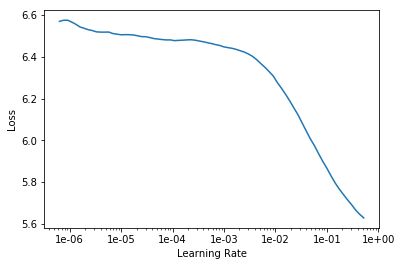

In [19]:
learn.recorder.plot(skip_end=15)

### Initial model training

Full data set took about 13 hours using the Nvidia P1000; Full data set was predicted to take about 25 hours with the T4

10% data is predicted to take about 1 hour (1:10) using the Nvidia P1000

In [20]:
# no idea how long nor how much resources this will take
# not sure 1e-2 is the right learning rate; maybe 1e-1 or between 1e-2 and 1e-1
# using t4
# progress bar says this will take around 24 hours... ran for about 52 minutes
# gpustat/nvidia-smi indicates currently only using about 5GB of GPU RAM
# using p100
# progress bar says this will take around 12 hours; took 13:16
# at start GPU using about 5GB RAM
# after about 8 hours GPU using about 7.5GB RAM.
# looks like I could increase batch size...
# with bs=64, still only seems to be using about 7GB GPU RAM after running for 15 minutes. will check after a bit, but likely can increase batch size further
learn.fit_one_cycle(1, 5e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.573480,2.400864,0.541587,1:08:18


In [21]:
learn.save(base_path/'mimic_fit_head.pickle')

In [15]:
learn.load(base_path/'mimic_fit_head.pickle')
print('loaded learner')

loaded learner


In [16]:
learn.unfreeze()

In [17]:
# at batch size of 128 takes about 1:14:00 per epoch
#       GPU usage is about 14GB; RAM usage is about 10GB
# at batch size of 96 takes about 1:17:00 per epoch
#       GPU usage is about 9GB; RAM usage is about 10GB
# at batch size of 48 takes about 1:30:00 per epoch
#       GPU usage is about 5GB; RAM usage is about 10GB
# would changing batch size improve training time? (larger batch size vs smaller batch size?)
learn.fit_one_cycle(8, 5e-3, moms=(0.8,0.7))
# 8 cycles gets from about 62.7% accuracy to 67.6% accuracy

epoch,train_loss,valid_loss,accuracy,time
0,1.926960,1.832659,0.627496,1:14:14
1,1.808083,1.755725,0.637424,1:14:15
2,1.747903,1.697741,0.645431,1:14:15
3,1.714081,1.652703,0.652703,1:14:19
4,1.637801,1.602961,0.660170,1:14:15
5,1.596906,1.553225,0.668557,1:14:14
6,1.572020,1.519172,0.674477,1:14:26
7,1.517364,1.510010,0.676342,1:14:14


In [18]:
learn.save(base_path/'mimic_fine_tuned.pickle')

In [ ]:
learn.fit_one_cycle(1, 5e-3, moms=(0.8,0.7))
learn.save(base_path/'mimic_fine_tuned.pickle')

epoch,train_loss,valid_loss,accuracy,time


In [ ]:
learn.load(base_path/'mimic_fine_tuned.pickle')

In [20]:
# test the language generation capabilities of this model (not the point, but is interesting)
TEXT = "For confirmation, she underwent CTA of the lung which was negative for pulmonary embolism"
N_WORDS = 40
N_SENTENCES = 2
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

For confirmation, she underwent CTA of the lung which was negative for pulmonary embolism 
  but showed no PE , but did show some pulmonary edema . She has had 
  some mild dyspnea on exertion but has improved . She was brought to the 
  ED for further evaluation
For confirmation, she underwent CTA of the lung which was negative for pulmonary embolism or dissection . 
  She was extubated today and given 1 unit of prbcs for Hct of 24 . She is 
  afebrile , HR in the 120s , BP stable . She is


In [21]:
learn.save_encoder('mimic_fine_tuned_enc.pickle')